# Классификация рукописных цифр базы MNIST

In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

from support import train_model, compute_loss_accuracy, Flattener

In [15]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("CUDA")
else:
    device = torch.device('cpu')
    print("CPU")

CPU


Загружаем тренировочные данные

In [11]:
train_data = dset.MNIST('./data/', train=True, download=True,
                    transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43],
                                               std=[0.20])
                       ]))

Отобразим данные

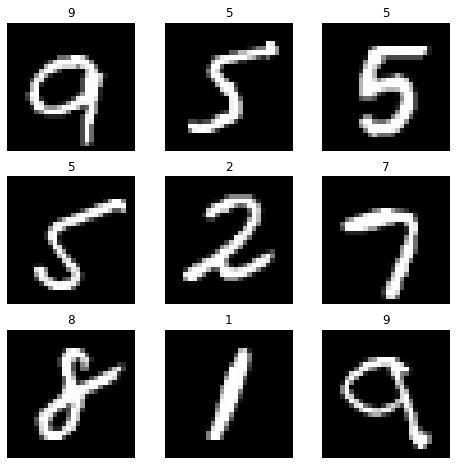

In [12]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Разделим тренировочные данные на тренировочные и валидационные

In [13]:
data_size = train_data.data.shape[0]
validation_proc = 0.2
split = int(np.floor(validation_proc * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         sampler=val_sampler)

### Создаем и тренируем модель
Цели модели - достичь точности на тренировочных данных более 98% с менее чем 10.000 параметрами

In [18]:
# 6010 Параметров

model = nn.Sequential(
        # In 28x28@1, out 28x28@8 - 80 параметра
        nn.Conv2d(1, 8, 3, padding=2),
        nn.BatchNorm2d(num_features=8),
        nn.ReLU(inplace=True),

        # In 28x28@8, out 14x14@8
        nn.MaxPool2d(kernel_size=2),

        # In 14x14@8, out 12x12@16 - 160 параметра
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
        nn.BatchNorm2d(num_features=16),
        nn.ReLU(inplace=True),

        # In 12x12@16, out 6x6@16
        nn.MaxPool2d(kernel_size=2),


        Flattener(),

        # O7 In 6*6*16, out 10 - 5770 параметров
        nn.Linear(6*6*16, 10),
      )

model.type(torch.FloatTensor)
model.to(device)

# Подобранные гиперпараметры для обучения сети
learning_rates = 10**-2
weight_decay = 10**-4
step_size = 1
gamma = 0.6
num_epochs = 15

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rates, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, train_loader, valid_loader, loss, optimizer, num_epochs, device, scheduler=scheduler, scheduler_loss=False)

Epoch #0 - train loss: 0.146808, accuracy: 0.954750 | val loss: 0.092629, accuracy: 0.971500
Epoch #1 - train loss: 0.049103, accuracy: 0.985125 | val loss: 0.061797, accuracy: 0.980667
Epoch #2 - train loss: 0.034140, accuracy: 0.988542 | val loss: 0.059324, accuracy: 0.982083
Epoch #3 - train loss: 0.025178, accuracy: 0.992146 | val loss: 0.051237, accuracy: 0.984583
Epoch #4 - train loss: 0.020239, accuracy: 0.993833 | val loss: 0.046568, accuracy: 0.985333
Epoch #5 - train loss: 0.015522, accuracy: 0.995750 | val loss: 0.047723, accuracy: 0.984833
Epoch #6 - train loss: 0.013201, accuracy: 0.996625 | val loss: 0.046882, accuracy: 0.985917
Epoch #7 - train loss: 0.011558, accuracy: 0.997354 | val loss: 0.046846, accuracy: 0.984917
Epoch #8 - train loss: 0.010664, accuracy: 0.997667 | val loss: 0.046822, accuracy: 0.986417
Epoch #9 - train loss: 0.010169, accuracy: 0.997687 | val loss: 0.046137, accuracy: 0.985917
Epoch #10 - train loss: 0.009778, accuracy: 0.998000 | val loss: 0.047

Нарисуем график ошибок и точности во время тренировки

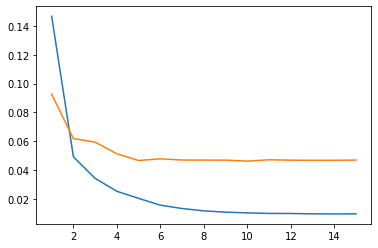

In [19]:
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label="train loss")
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label="validate loss")
plt.show()

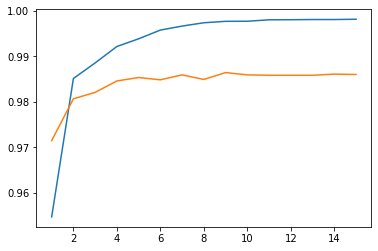

In [20]:
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history)
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history)
plt.show()

Сохраняем модель для последующих тестов

In [22]:
torch.save(model, "./model_v3.pt")